In [50]:
import numpy as np
import glob
import os
import shutil
import matplotlib.pyplot as plt

#Install scipy, astropy and iminuit
from scipy.signal import find_peaks
from astropy.table import Table
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [54]:
scans_name = './2022-03-17-Scans/Scans/*.txt'
scans = sorted(glob.glob(scans_name)) 
date = scans_name.split('/')[1] 

#Create paths to save intermediate results
path1 = './2022-03-17-Scans/fit_quality'
if not os.path.exists(path1):
    os.makedirs(path1) #save figures with fits
else:
    shutil.rmtree(path1) #overwrite folders if exist
    os.makedirs(path1)
    
for i in range(9):
    paths = './2022-03-17-Scans/fit_quality/board'+str(i) #subdirectories for different boards
    if not os.path.exists(paths):
        os.makedirs(paths) #save figures with fits
    else:
        shutil.rmtree(paths)
        os.makedirs(paths) 
    
path2 = './2022-03-17-Scans/fit_parameters' #save fit parameters
if not os.path.exists(path2):
    os.makedirs(path2) 
else:
    shutil.rmtree(path2)
    os.makedirs(path2)
    
#Define mapping dict
board_dict={
    'board0': np.arange(0,8),
    'board1': np.arange(8,16), #if only has scans for bore + bottom paddle, then here is 'board5'.
    'board2': np.arange(16,24), #or 'board6'. The board name doesn't really matter. As long as the range is correct. 
    'board3': np.arange(24,32), #or 'board7'.
    'board4': np.arange(32,40), #or 'board8'.
    'board5': np.arange(40,48),
    'board6': np.arange(48,56),
    'board7': np.arange(56,64),
    'board8': np.arange(64,72)
    }

board_list = ['board0', 'board1', 'board2', 'board3', 'board4', 'board5','board6','board7','board8']

In [16]:
#Plot scans
#b_num = 9
b_num = 5 #This scan only has bore + bottom. Later you will need b_num = 9, if the scan has bore + top + bottom
for b in range(b_num): 
    plt.figure(figsize=(20,16))
    for j in board_dict[board_list[b]]:
        for s in [0]:
            run = Table.read(scans[j], format='ascii')
            SiPMs = run.columns[1]
            SiPMs = np.array(SiPMs)
            SiPM = np.where(SiPMs==s)[0]
            thrd = run.columns[4][SiPM]*1000
            rate = run.columns[7][SiPM]
            name = scans[j].split('/')[3][9:23] + '_SiPM_' + str(s)

            plt.plot(thrd, rate, marker='.', label=name)
            plt.yscale('log')
            plt.legend(loc='right')
            plt.title('Board'+scans[j].split('/')[3][15], fontsize=36)
            plt.xlabel('Thresholds (mV)',fontsize=16)
            plt.ylabel('Dark count rate (Hz)',fontsize=16)
            plt.rc('xtick', labelsize=14) 
            plt.rc('ytick', labelsize=14) 
    plt.savefig('./'+date+'/Board'+scans[j].split('/')[3][15]+'.jpg')
    plt.close()

In [60]:
b=4 #change board number here. b = [0,1,2,3,4] if the scan only has bore+bottom.

fit_matrix = []
chan_names = []

for k in board_dict[board_list[b]]: 
    for s in [0,1,2,3]:
        data = Table.read(scans[k], format='ascii') 
        name = scans[k].split('/')[3][9:23]+'_SiPM_'+str(s)
        figname = './'+date+'/fit_quality/'+'board'+scans[k].split('/')[3][15] +'/'+ name
        chan_names.append(name)
        
        data = data[ data['col2']==s ]
        xs = np.array( data['col5'] ) * 1000
        ys = np.array( data['col8'] )
        log_ys = np.log10(ys)

        # Fine the ending points of the line
        max_idx = np.argmax( log_ys )
        x1, log_y1 = xs[max_idx], log_ys[max_idx]
        min_idx = max_idx + np.argmin( log_ys[max_idx:] )
        x2, log_y2 = xs[min_idx], log_ys[min_idx]
        # Fine the line, log_y = Ax + B
        A = (log_y1-log_y2) / (x1-x2)
        B = (log_y2*x1-log_y1*x2) / (x1-x2)

        # Calcualte signed distance between the curve and the line
        # det_y defines the sign (below is positive)
        det_log_ys = -log_ys + A*xs + B
        det_xs = np.abs( det_log_ys/A )
        ds = det_xs*det_log_ys / (det_xs**2+det_log_ys**2)**0.5
        # Correct nan when distance = 0
        ds[ np.isnan(ds) ] = 0

        # Find peaks
        peak_idxs = max_idx + find_peaks(ds[max_idx:], prominence=0.05)[0]
        
        # Some exceptions
        if (b==3) and (k==24) and (s==0): 
            peak_idxs = np.append( np.append(70, peak_idxs), 170 )
        if (b==3) and (k==24) and (s in [1,2,3]): 
            peak_idxs = np.append(peak_idxs, 160)  
        if (b==3) and (k==25):
            peak_idxs = np.append( np.append(65, peak_idxs), 134 )        
        if (b==4) and (k==32):
            peak_idxs = max_idx + find_peaks(ds[max_idx:], prominence=0.03)[0]
            peak_idxs = np.append(peak_idxs, 130)
        if (b==4) and (k==34):
            peak_idxs = max_idx + find_peaks(ds[max_idx:], prominence=0.03)[0]
            peak_idxs = np.append(peak_idxs, 140)
        
            
        # Fine the x,y to fit
        fit_xs = xs[:peak_idxs[2]]
        fit_ys = ys[:peak_idxs[2]]

        # Remove low values
        use_idxs = np.where(fit_ys>=10**6.5)[0][0]
        fit_xs = fit_xs[use_idxs:]
        fit_ys = fit_ys[use_idxs:]

        # Define the function to fit
        def fit_func(x, Ap, x0p, bp, cp, frac_A1, det_x01, b1, c1, frac_A2, det_x02, b2):
            x01 = x0p + det_x01
            x02 = x01 + det_x02
            A1 = Ap * frac_A1
            A2 = A1 * frac_A2
            
            gausp = Ap*np.exp(-1/2*abs((x - x0p)/bp)**cp)
            gaus1 = A1*np.exp(-1/2*abs((x - x01)/b1)**c1)
            sigm2 = A2/(1+np.exp((x - x02)/b2))
            return np.log10( gausp + gaus1 + sigm2 )

        # Define the lost function, chi2
        least_squares = LeastSquares(fit_xs, np.log10(fit_ys), np.ones(len(fit_ys)), fit_func)

        # Set the initial value
        x0p_ini = (fit_xs[0]+xs[peak_idxs[0]])/2
        x01_ini = (xs[peak_idxs[0]]+xs[peak_idxs[1]])/2
        x02_ini = (xs[peak_idxs[1]]+xs[peak_idxs[2]])/2
        cp_ini, c1_ini = 2., 2.
        bp_ini, b1_ini, b2_ini = (fit_xs[-1]-fit_xs[0])/6, (fit_xs[-1]-fit_xs[0])/6, (fit_xs[-1]-fit_xs[0])/6
        Ap_ini = np.interp(x0p_ini, xs, ys) 
        A1_ini = np.interp(x01_ini, xs, ys) 
        A2_ini = np.interp(x02_ini, xs, ys)*2
        det_x01_ini = x01_ini - x0p_ini
        det_x02_ini = x02_ini - x01_ini
        frac_A1_ini = A1_ini / Ap_ini
        frac_A2_ini = A2_ini / A1_ini

        # Set the initial value
        m = Minuit(least_squares, 
                   Ap=Ap_ini, x0p=x0p_ini, bp=bp_ini, cp=cp_ini, 
                   frac_A1=frac_A1_ini, det_x01=det_x01_ini, b1=b1_ini, c1=c1_ini, 
                   frac_A2=frac_A2_ini, det_x02=det_x02_ini, b2=b2_ini) 

        # Set parameter limit
        m.limits['x0p'] = (fit_xs[0], None)
        m.limits['det_x01'] = (0.1, fit_xs[-1]-fit_xs[0])
        m.limits['det_x02'] = (0.1, fit_xs[-1]-fit_xs[0])
        m.limits['Ap'] = (0, None)
        m.limits['frac_A1'] = (0, 1)
        m.limits['frac_A2'] = (0, 1)

        m.limits['cp'] = (0, 10)
        m.limits['c1'] = (0, 10)
        m.limits['bp'] = (0, None)
        m.limits['b1'] = (0, None)
        m.limits['b2'] = (0, None)

        # Fit
        # Gradually free parameteres 
        m.fixed = True

        m.fixed['Ap'] = False
        m.fixed['x0p'] = False
        _ = m.migrad()#; print(m.valid)

        m.fixed['frac_A1'] = False
        m.fixed['det_x01'] = False
        _ = m.migrad()#; print(m.valid)

        m.fixed['frac_A2'] = False
        m.fixed['det_x02'] = False
        _ = m.migrad()#; print(m.valid)

        m.fixed['bp'] = False
        m.fixed['b1'] = False
        m.fixed['b2'] = False
        _ = m.migrad()#; print(m.valid)

        m.fixed['c1'] = False
        m.fixed['cp'] = False
        _ = m.migrad()#; print(m.valid)

        # Plot the result
        plt.figure(figsize=(6,4))
        figname
        plt.plot( fit_xs, np.log10(fit_ys), '.')
        plt.plot( fit_xs, fit_func(fit_xs, *m.values) )
        plt.savefig(figname)
        plt.close()
        
        Ap, A1, A2 = m.values['Ap'], m.values['Ap']*m.values['frac_A1'], m.values['Ap']*m.values['frac_A1']*m.values['frac_A2']
        x0p, bp, cp = m.values['x0p'], m.values['bp'], m.values['cp']
        x01, b1, c1 = m.values['x0p']+m.values['det_x01'], m.values['b1'], m.values['c1']
        x02, b2 = m.values['x0p']+m.values['det_x01']+m.values['det_x02'], m.values['b2']
        
        B1 = 0.5*(1 + A1/Ap)
        B2 = 0.5*(1 + A2/(A1*(1+np.exp(-x02/b2))))
        
        Xp = x0p + bp*((np.log(1/B1**2))**(1/cp))
        X1 = x01 + b1*((np.log(1/B2**2))**(1/c1))
        X2 = x02
        
        fit_matrix.append([Ap, A1, A2, x0p, bp, cp,
                           x01, b1, c1, x02, b2, 
                           B1, B2, Xp, X1, X2])
        

fit_matrix = np.array(fit_matrix)

tab = Table(fit_matrix, names=['Ap', 'A1', 'A2', 'x0p', 'bp', 'cp',
                         'x01', 'b1', 'c1','x02', 'b2', 
                         'B1', 'B2', 'Xp', 'X1', 'X2'])

tab.add_column(Table.Column(chan_names, name='chan'), index=0)
tab.write('./'+date+'/fit_parameters/'+date+'_board'+scans[k].split('/')[3][15]+'.dat', 
          format='ascii.commented_header', overwrite=True)


/var/folders/hg/94pnk0m50dqb6qh085z7z1zw0000gn/T/ipykernel_11204/377324333.py:31: RuntimeWarning: invalid value encountered in true_divide
  ds = det_xs*det_log_ys / (det_xs**2+det_log_ys**2)**0.5
/var/folders/hg/94pnk0m50dqb6qh085z7z1zw0000gn/T/ipykernel_11204/377324333.py:31: RuntimeWarning: invalid value encountered in true_divide
  ds = det_xs*det_log_ys / (det_xs**2+det_log_ys**2)**0.5
/var/folders/hg/94pnk0m50dqb6qh085z7z1zw0000gn/T/ipykernel_11204/377324333.py:31: RuntimeWarning: invalid value encountered in true_divide
  ds = det_xs*det_log_ys / (det_xs**2+det_log_ys**2)**0.5
/var/folders/hg/94pnk0m50dqb6qh085z7z1zw0000gn/T/ipykernel_11204/377324333.py:31: RuntimeWarning: invalid value encountered in true_divide
  ds = det_xs*det_log_ys / (det_xs**2+det_log_ys**2)**0.5
/var/folders/hg/94pnk0m50dqb6qh085z7z1zw0000gn/T/ipykernel_11204/377324333.py:31: RuntimeWarning: invalid value encountered in true_divide
  ds = det_xs*det_log_ys / (det_xs**2+det_log_ys**2)**0.5
/var/folders/hg

In [123]:
peak_idxs

array([ 68, 115])

In [99]:
from scipy.signal import argrelextrema

find_peaks( ds[max_idx:], prominence=0.01)

(array([ 13,  59, 111, 122, 125, 127, 129, 132, 135, 137]),
 {'prominences': array([0.05350489, 0.1197825 , 0.0213954 , 0.01152868, 0.03937388,
         0.03278253, 0.01699209, 0.01489688, 0.01332871, 0.01471232]),
  'left_bases': array([  6,  45,  45,  45,  45,  45, 128,  45,  45,  45]),
  'right_bases': array([ 45,  86, 119, 123, 126, 128, 130, 134, 136, 138])})

In [100]:
peak_idxs = max_idx + find_peaks( ds[max_idx:], prominence=0.05)[0]
xs[peak_idxs]

array([13.67, 22.85])

In [104]:
b, k, s

(4, 32, 0)

In [116]:
np.abs(xs-28).argmin()

139

In [72]:
xs[max_idx + find_peaks(ds[max_idx:], prominence=0.01)[0]]

array([19.53, 27.34, 28.32, 29.49, 30.86, 35.74, 36.72, 37.3 , 39.45])

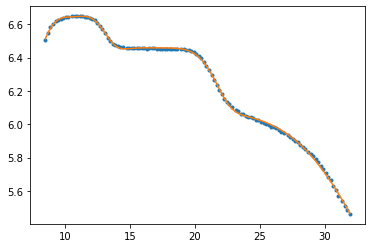

In [125]:
#m = Minuit(least_squares, Ap=Ap_ini, x0p=x0p_ini, bp=bp_ini, cp=cp_ini, A1=A1_ini, det_x01=det_x01_ini, 
#           b1=b1_ini, c1=c1_ini, A2=A2_ini, det_x02=det_x02_ini, b2=b2_ini) 
plt.plot( fit_xs, np.log10(fit_ys), '.')
plt.plot( fit_xs, fit_func(fit_xs, *m.values) )

/var/folders/hg/94pnk0m50dqb6qh085z7z1zw0000gn/T/ipykernel_16665/1956160341.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(xs[max_idx:], np.log10(ys)[max_idx:], '.')


(3.0, 7.0)

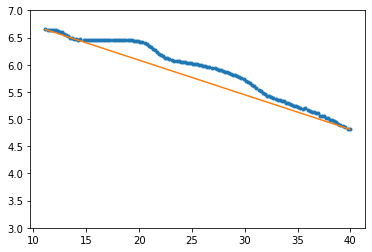

In [119]:
plt.plot(xs[max_idx:], np.log10(ys)[max_idx:], '.')
plt.plot(xs[max_idx:], (A*xs+B)[max_idx:], '-')
plt.ylim(3,7)
#plt.yscale('log')
#plt.ylim(1e5, 1e7)

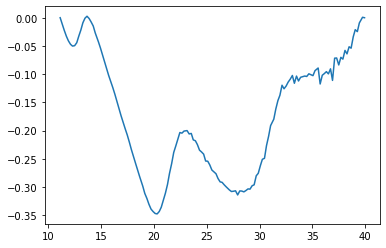

In [120]:
plt.plot(xs[max_idx:], ds[max_idx:])

In [69]:
xs[peak_idxs]

array([13.87, 34.08])